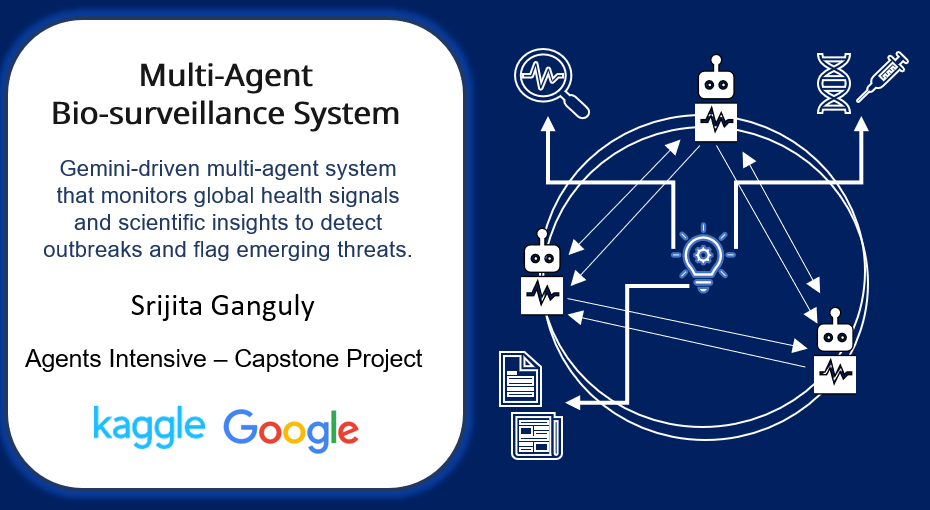

**This is the Agent Intensive - Capstone Project            (Kaggle x Google):**
I have applied the Kaggle × Google 5-Days Agents Intensive Course learnings to develop this system with GoogleADK.

It contains all the essential code required to run and explore the **Multi-Agent Biosurveillance System**, including demonstrations of the agents.

**Contents:**

1. **Setup:** Installation and import of required libraries
2. **API Key Configuration**
3. **Step 1:** Custom tools setup
4. **Step 2:** LLM configuration and Sequential Multi-Agent setup
5. **Step 3:** Main Orchestrator — ChatBot configuration
6. **Step 4:** Session setup
7. **Step 5:** Agent observability setup
8. **ADK WebUI Integration with Kaggle**
9. **Features Summary**
10. **Limitations and Future Improvements**
---

### **Setup: Installation and import of required libraries**  

In [ ]:
#Install Google-ADK
!pip install google-adk

In [ ]:
#Import required libraries
from google.adk.agents import Agent, SequentialAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import InMemoryRunner
from google.genai import types
from google.adk.apps.app import App, EventsCompactionConfig
from google.adk.agents import Agent, LlmAgent
from google.adk.sessions import InMemorySessionService
from google.adk.sessions import DatabaseSessionService
from google.adk.runners import Runner
from google.adk.tools.tool_context import ToolContext
from typing import Any, Dict, List
from google.adk.tools import load_memory, preload_memory
from google.adk.memory import InMemoryMemoryService
from google.adk.tools.agent_tool import AgentTool
import requests
from google.adk.plugins.logging_plugin import (LoggingPlugin,)
import asyncio

print("✅ ADK components imported successfully.")

✅ ADK components imported successfully.


###**API Key Configuration**

In [ ]:
#Setup the API Keys
import os
import re
from google.colab import userdata

#Setup the Google API Key
api_key=userdata.get('GOOGLE_API_KEY')
os.environ["GOOGLE_API_KEY"] = api_key

#Setup the Serper API Key
serper_api_key=userdata.get('SERPER.DEV_API_KEY')

#Setup NCBI API Key
NCBI_api_key=userdata.get('NCBI_API_KEY')

print("✅ API keys setup complete.")

✅ API keys setup complete.


In [ ]:
#Configure Retry Options
#When working with LLMs, you may encounter transient errors like rate limits or temporary service unavailability. Retry options automatically handle these failures by retrying the request with exponential backoff.
retry_config=types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1, # Initial delay before first retry (in seconds)
    http_status_codes=[429, 500, 503, 504] # Retry on these HTTP errors
)

### **Step 1: Custom Tools Setup**

In [ ]:
# 1. RAW NEWS COLLECTION
def get_disease_outbreak_news(query: str, num_results: int = 5) -> List[Dict[str, str]]:
    """
    Fetch news from Serper.dev News API.
    This function has an ADK-safe signature: only primitive input args.
    """

# 🔑 Use your Serper API key
    api_key = serper_api_key

# 🧾 Query payload (what you are asking the news API to search for)
    url = "https://google.serper.dev/news"
    headers = {"X-API-KEY": api_key}
    payload = {"q": query}

# 📡 Send POST request to Serper API to get the news articles
    response = requests.post(url, headers=headers, json=payload)

# ❌ Error handling: if API fails, print status and return empty list
    if response.status_code != 200:
        print(f"News failed ({response.status_code}): {response.text}")
        return []

    data = response.json()

# 🧩 Extract the "news" list and limit to the requested number of results
    articles = data.get("news", [])[:num_results]

# 📦 Build a simplified, clean list of article dictionaries
    return [
        {
            "title":   item.get("title"),
            "link":    item.get("link"),
            "snippet": item.get("snippet"),
            "source":  item.get("source"),
        }
        for item in articles
    ]

# 2. FILTERED OUTBREAK NEWS FUNCTION
def disease_outbreak_news(query: str) -> List[Dict[str, str]]:
    """
    Fetch current microbial or viral outbreak news using the Serper News API.
    Applies filtering for emerging infectious disease–related content.

    Returns:
        List[Dict[str, str]]
    """

# 📰 First, get the raw news articles using the function above
    raw_news = get_disease_outbreak_news(query)

# 🧬 Keywords to identify outbreak-related stories
    outbreak_keywords = [
        "virus", "bacteria", "fungus", "fungal",
        "prion", "parasite",
        "outbreak", "cluster", "disease",
        "epidemic", "pandemic",
        "infection", "infectious", "news",
        "pathogen", "case count",
    ]

# 🔍 Evaluate each article to check for outbreak-related keywords
    filtered = []
    for item in raw_news:
        text = f"{item['title']} {item['snippet']}".lower()

        if any(keyword in text for keyword in outbreak_keywords):
            filtered.append(item)

# 📤 Return only the filtered outbreak-related articles
    return filtered

print("✅ The `get_disease_outbreak_news` and `disease_outbreak_news` tools are created.")

✅ The `get_disease_outbreak_news` and `disease_outbreak_news` tools are created.


In [ ]:
#1. RESEARCH PAPERS COLLECTION AND FILTERING
def get_pubmed_papers(query: str, max_results: int = 20) -> List[Dict[str, Any]]:
    """
    Fetch research papers from PubMed.
    Applies filtering for infectious disease–related content.
    """

# 🔑 NCBI API key for PubMed E-utilities access
    api_key = NCBI_api_key

# 🧾 Search parameters:

    #    - term=query          → your input search query
    #    - retmax=max_results  → max number of IDs to return
    #    - retmode="json"      → request JSON response

    search_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    search_params = {
        "db": "pubmed",
        "term": query,
        "retmax": max_results,
        "api_key": api_key,
        "retmode": "json"
    }

# 📡 Send the search request
    search_response = requests.get(search_url, params=search_params)
    ids = search_response.json().get("esearchresult", {}).get("idlist", [])

# ❌ No IDs returned → no papers found, return empty list
    if not ids:
        return []

# 🧾 parameters:
    #    - db="pubmed"       → get from PubMed database
    #    - id="comma list"   → get multiple IDs at once
    #    - retmode="xml"     → efetch returns XML

    get_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    get_params = {
        "db": "pubmed",
        "id": ",".join(ids),
        "retmode": "xml",
        "api_key": api_key
    }

  # 📡 Send the fetch request for full article details
    get_response = requests.get(get_url, params=get_params)

# 📦 Parse returned XML with BeautifulSoup
    from bs4 import BeautifulSoup
    soup = BeautifulSoup(get_response.text, "xml")

    papers = []
    for article in soup.find_all("PubmedArticle"):

      # 🏷️ Title (if available)
        title = article.ArticleTitle.text if article.ArticleTitle else None

      # 📝 Abstract (may be missing)
        abstract = (
            article.Abstract.AbstractText.text
            if article.Abstract and article.Abstract.AbstractText
            else None
        )

      # 📰 Journal name
        journal = (
            article.Journal.Title.text
            if article.Journal and article.Journal.Title
            else None
        )

      # 👥 Author list extraction (first + last names)
        authors = []
        for author in article.find_all("Author"):
            first = author.ForeName.text if author.ForeName else ""
            last = author.LastName.text if author.LastName else ""
            if first or last:
                authors.append(f"{first} {last}")

      # 🔗 DOI identifier
        doi_tag = article.find("ArticleId", {"IdType": "doi"})
        doi = doi_tag.text if doi_tag else None

      # 📄 Append paper metadata to list
        papers.append(
            {
                "doi": doi,
                "title": title,
                "abstract": abstract,
                "journal": journal,
                "authors": authors,
            }
        )

# 📤 Return the list of processed papers
    return papers

print("✅ The `get_pubmed_papers` tool is created.")

✅ The `fetch_pubmed_papers` tool is created.


### **Step 2: LLM configuration and Sequential Multi-Agent setup**

In [ ]:
# NEWS ON INFECTIOUS DISEASES

# Create an LLM-powered agent that analyzes infectious-disease news
news_surveillance_agent = LlmAgent(
    name="newssurveillanceagent",        # 🔹 Unique agent name (used internally in ADK)
    model=Gemini(
        model="gemini-2.5-flash-lite",   # ⚡ Lightweight, fast Gemini model for surveillance tasks
        retry_options=retry_config       # 🔁 Retry logic for API robustness
    ),

    instruction="""
You are the **NEWS Surveillance Analyzer (SP)**.
Your only job is to generate a short, data-driven Surveillance Report using the 'disease_outbreak_news' tool.

---

# OUTPUT FORMAT (MANDATORY — NO EXCEPTIONS)

### 1. Threat Assessment
State the current risk level (LOW / MODERATE / HIGH) and give one short justification.

### 2. Epidemic Trends
Summarize key indicators such as trend direction.
Do not invent values not present in the data.

### 3. Geographic Distribution
List the relevant hotspots or monitored regions based strictly on the provided data.

### 4. References
"references": [
       {
          "title": "...",
          "link": "...",
          "source": "..."
       }
  ]

---

# RULES
- Do not invent data.
- Include ALL article links from the tool output in "references".
- Use ONLY the simulated data given in the prompt.
- Do NOT add, guess, or extrapolate new statistics.
- No external assumptions.
- Keep the report concise, factual, and neutral.

""",

# These tools allow the agent to collect and filter real news articles
    tools=[disease_outbreak_news, get_disease_outbreak_news]
)

print("✅ Your news_surveillance_agent is created.")

✅ Your news_surveillance_agent is created.


***Demonstration of `news_surveillance_agent`:***

In [ ]:
# 🧠 InMemoryRunner:
# Runs the agent entirely in memory
runner = InMemoryRunner(agent=news_surveillance_agent)

# 🧪 Run the agent in debug mode:
response = await runner.run_debug(
    "What is the news on infectious diseases ?"
)



 ### Created new session: debug_session_id

User > What is the news on infectious diseases ?
newssurveillanceagent > ### 1. Threat Assessment
MODERATE - Several infectious diseases, including norovirus, E. coli, measles, Marburg virus, and bird flu, are currently active or under investigation globally.

### 2. Epidemic Trends
Norovirus cases are rising in the US, and global measles cases surpassed pre-Covid levels in 2024. Bird flu viruses are noted as a significant threat due to their fever resistance.

### 3. Geographic Distribution
Hotspots and monitored regions include the US (norovirus, E. coli), Ethiopia (Marburg virus), and global (measles, bird flu).

### 4. References
[{"title": "Cases of infectious norovirus are rising across the US this holiday season", "link": "https://www.the-independent.com/news/health/norovirus-cases-us-holiday-infections-b2873219.html", "source": "The Independent"}, {"title": "Notes from the Field: Outbreak of Escherichia coli ...", "link": "https://ww

In [ ]:
#A. RESEARCH PAPER FINDER

# Create an LLM-powered agent for collecting research papers from PubMed
research_paper_finder_agent = LlmAgent(
    name="paperingestion",              # 🔹 Unique agent name for internal tracking
    model=Gemini(
        model="gemini-2.5-flash-lite",  # ⚡ Lightweight Gemini model for fast response
        retry_options=retry_config),    # 🔁 Retry logic to handle transient API failures
    instruction="""
        You are a research paper ingestion agent.
        Use the get_pubmed_papers tool whenever the user requests:
        - research papers
        - PubMed articles
        - biomedical literature
        - research work
        - recent research
        Return structured metadata (DOI, title, authors, abstract, journal).
        If full text is requested, explain whether full text is available via PubMed or must be accessed externally.
    """,

# Only the `get_pubmed_papers` tool is available, so the agent can retrieve PubMed research papers as requested.
    tools=[get_pubmed_papers],

# Defines the key under which the agent’s structured response is stored.
    output_key="paper_metadata"
)

print("✅ Your research_paper_finder_agent is created.")

✅ Your research_paper_finder_agent is created.


In [ ]:
#B. RESEARCH EXTRACTOR

# Create an LLM-powered agent to extract structured information from research paper metadata retrieved by the research_paper_finder_agent.
research_extractor_agent = LlmAgent(
    name="researchextractor",         # 🔹 Unique name for internal tracking
    model=Gemini(
        model="gemini-2.5-flash-lite",# ⚡ Lightweight model suitable for extraction tasks
        retry_options=retry_config),  # 🔁 Retry logic to handle transient failures
    instruction="""
    Using the output of 'paper_metadata'
    Extract structured fields:
    - DOI
    - pathogen
    - variant
    - virulence_factor
    - gene_or_protein
    - mechanism
    - mutations
    - evidence_strength
    - date
    Format output as JSON list.

    # OUTPUT FORMAT (MANDATORY — NO EXCEPTIONS)
[
  {
    "doi": "...",
    "pathogen": "...",
    "variant": "...",
    "virulence_factor": "...",
    "gene_or_protein": "...",
    "mechanism": "...",
    "mutations": "...",
    "evidence_strength": "...",
    "date": "...",
    "reference": {
         "doi": "..."
    }
  }
]

• Ensure the DOI is always included inside "reference".
    """,
)

# Note: No additional tools are required, this agent works purely on the metadata produced by the previous agent.

print("✅ Your research_extractor_agent is created.")

✅ Your research_extractor_agent is created.


In [ ]:
#C. BIOSURVEILLANCE

# Create a SequentialAgent that chains multiple agents together
# This agent performs a complete biosurveillance workflow:
# 1️⃣ Collect research papers
# 2️⃣ Extract structured pathogen-related information
bio_surveillance_agent = SequentialAgent(
    name="biosurveillanceagent",            # 🔹 Unique name for internal tracking
    sub_agents=[
        research_paper_finder_agent,        # Step 1: Get PubMed research papers
        research_extractor_agent,           # Step 2: Extract structured information from papers
    ]
)

print("✅ Your bio_surveillance_agent is created.")

✅ Your bio_surveillance_agent is created.


***Demonstration of `bio_surveillance_agent`:***

In [ ]:
# 🧠 InMemoryRunner:
# Runs the SequentialAgent entirely in memory.
runner = InMemoryRunner(agent=bio_surveillance_agent)

# 🧪 Run the agent in debug mode:
response = await runner.run_debug(
    "What the research state about Marburg virus disease ?"
)



 ### Created new session: debug_session_id

User > What the research state about Marburg virus disease ?
paperingestion > Marburg virus disease (MVD) is a highly virulent pathogen that causes acute hemorrhagic fever outbreaks. Despite its potential to cause explosive outbreaks and pose a threat to public health, MVD remains significantly under-researched, with a notable lack of comprehensive scientific evidence. This limited attention has resulted in gaps in understanding its epidemiology, clinical management, and prevention strategies.

Recent research has focused on several key areas:

*   **Reservoir and Transmission:** Egyptian rousette bats (ERBs) are identified as the natural reservoir for Marburg virus (MARV). Studies are investigating how the virus is maintained within bat populations and the mechanisms behind zoonotic spillover events. Recent outbreaks in regions without prior records, such as Ghana, Tanzania, Equatorial Guinea, and Rwanda, challenge the current understanding

In [ ]:
# AGGREGATION OF THE NEWS AND RESEARCH OUTPUTS

# Create an LLM-powered agent that fuses outputs from news and research pipelines
data_aggregator_agent = LlmAgent(
    name="dataaggregatoragent",            # 🔹 Unique agent name for tracking
    model=Gemini(
        model="gemini-2.5-flash-lite",     # ⚡ Lightweight model suitable for summarization and fusion tasks
        retry_options=retry_config         # 🔁 Retry logic for robustness
    ),

    instruction="""
You are the Fusion Intelligence Agent.

You will receive:
- news_surveillance_output
- bio_surveillance_output

Your job is to integrate these into a unified analytic snapshot.

────────────────────────────────────────
FUSION TASKS (MANDATORY)
────────────────────────────────────────
1. Aggregate both inputs into a single, concise summary:
    • Key pathogen(s)
    • Relevant mutations or molecular signals
    • Outbreak regions or clusters
    • CRITICAL: Any apparent correlation between surveillance and research literatures

2. Apply the RISK ENGINE (rules below).

────────────────────────────────────────
RISK ENGINE RULES
────────────────────────────────────────
Assign a HIGH / MODERATE / LOW risk score:

- HIGH if:
    • surveillance mentions "rapid spread", "cluster expansion", or
    • molecular evidence includes "increased transmissibility",
      "immune escape", or "high-impact mutation".

- MODERATE if:
    • surveillance reports emerging but contained outbreaks OR
    • literature indicates mutations of uncertain significance.

- LOW if:
    • minimal surveillance signals AND
    • no concerning molecular factors.

────────────────────────────────────────
FUSION REQUIREMENTS
────────────────────────────────────────
1. Create a single concise analytic summary.
2. Apply the Risk Engine.
3. Aggregate ALL references:
    • News article links from surveillance
    • DOIs from molecular papers

────────────────────────────────────────
OUTPUT FORMAT (STRICT)
────────────────────────────────────────
{
  "fusion_summary": "...",
  "risk_level": "HIGH | MODERATE | LOW",
  "justification": "...",
  "references": {
        "news_articles": [
             {"title": "...", "link": "...", "source": "..."}
        ],
        "research_articles": [
             {"doi": "..."}
        ]
  }
}

────────────────────────────────────────
RULES:
• Do not fabricate references.
• Only use references passed by prior agents.
• Keep the summary concise.
""",
)

#THE FUSION PIPELINE — SEQUENTIAL AGENT

# Chain the agents into a complete fusion pipeline:
# 1️⃣ news_surveillance_agent → collects outbreak news
# 2️⃣ bio_surveillance_agent → collects and extracts structured research data
# 3️⃣ data_aggregator_agent → integrates outputs and produces a unified analytic snapshot

fusion_pipeline = SequentialAgent(
    name="fusion_pipeline",
    sub_agents=[
        news_surveillance_agent,      # existing surveillance agent
        bio_surveillance_agent,    # existing molecular evidence pipeline
        data_aggregator_agent                 # fusion layer
    ]
)


print("✅ Your fusion_pipeline is created.")

✅ Your fusion_pipeline is created.


***Demonstration of `fusion_pipeline`:***

In [ ]:
# 🧠 InMemoryRunner:
# Runs the full fusion_pipeline entirely in memory.
runner = InMemoryRunner(agent=fusion_pipeline)

# 🧪 Run the fusion pipeline in debug mode:
response = await runner.run_debug(
    "How the latest news and research aligns with Marburg virus disease?"
)


 ### Created new session: debug_session_id

User > How the latest news and research aligns with Marburg virus disease?
newssurveillanceagent > ### 1. Threat Assessment
MODERATE: Marburg virus disease has an up to 88% fatality ratio, and recent outbreaks in Ethiopia and Rwanda indicate its re-emergence.

### 2. Epidemic Trends
The trend indicates a re-emergence of Marburg virus disease, with recent outbreaks reported in Ethiopia and Rwanda. Research is focused on understanding human immune responses to the virus.

### 3. Geographic Distribution
Hotspots and monitored regions include Ethiopia and Rwanda.

### 4. References
"references": [
       {
          "title": "Global Virus Network outlines priorities as Marburg virus emerges in Ethiopia",
          "link": "https://www.news-medical.net/news/20251127/Global-Virus-Network-outlines-priorities-as-Marburg-virus-emerges-in-Ethiopia.aspx",
          "source": "News-Medical"
       },
       {
          "title": "Marburg Virus Disease in

### **Step 3: Main Orchestrator — ChatBot configuration**

In [ ]:
# THE MAIN ORCHESTRATOR: THE CHATBOT
root_agent = LlmAgent(
    name="InteractingAgent",              # 🔹 Unique root agent name
    model=Gemini(
        model="gemini-2.5-flash-lite",    # ⚡ Lightweight, fast model for orchestration
        retry_options=retry_config        # 🔁 Retry logic for API robustness
    ),

    instruction="""
You are the Pandemic Surveillance & Molecular-Evidence Orchestrator.

Your responsibilities are strictly limited to:
    (1) Providing optional high-level surveillance context on request
    (2) Extracting molecular evidence from scientific literature

────────────────────────────────────────────
SURVEILLANCE REQUEST ROUTING
────────────────────────────────────────────
If the user explicitly asks for:
    • surveillance
    • outbreak signals
    • global monitoring
    • epidemic situation
    • risk level
    • current news
    • latest information

Then you MUST immediately call the tool:
    news_surveillance_agent
and pass the entire user query as the input.

────────────────────────────────────────────
MOLECULAR-EVIDENCE ROUTING
────────────────────────────────────────────
If the user message contains ANY of the following words:
    virulence, virulence factor, mutation, variant,
    gene, protein, genomic, molecular, mechanism,
    sequence, strain, evidence, research,

Then you MUST immediately call the tool:
    bio_surveillance_agent
and pass the entire user query as the input.

────────────────────────────────────────────
FUSION ROUTING
────────────────────────────────────────────
If the user requests BOTH:
    • surveillance context
AND
    • molecular evidence

Then call the tool:
    fusion_pipeline

────────────────────────────────────────────
OUT OF SCOPE
────────────────────────────────────────────
If the query does not involve:
    • surveillance/outbreak context OR
    • molecular evidence

Respond ONLY with:

    "Hello! I am your research assistant. I can assist you with current surveillance reports and molecular-evidence analysis related to emerging or known diseases."

────────────────────────────────────────────
SAFETY
────────────────────────────────────────────
Never give wet-lab steps, genetic engineering instructions,
experimental workflows, or anything operational.
Only high-level summaries of published literature or simulated data.
""",

# These are wrapped sub-agents, enabling routing based on user intent:
    tools=[
        AgentTool(agent=news_surveillance_agent),
        AgentTool(agent=bio_surveillance_agent),
        AgentTool(agent=fusion_pipeline)
    ]
)

print("✅ Your root_agent, the main orchestrator is created.")

✅ Your root_agent, the main orchestrator is created.


***Demonstration of `root_agent`:***

In [ ]:
# 🧠 InMemoryRunner:
# Runs the root_agent entirely in memory.
runner = InMemoryRunner(agent=root_agent)

# 🧪 Run the root agent in debug mode:
response = await runner.run_debug(
    "what is the current news on marburg virus ?"
)


 ### Created new session: debug_session_id

User > what is the current news on marburg virus ?
PandemicPreventingAgent > The current news on Marburg virus indicates a moderate threat, with an increasing trend of cases and deaths reported in Ethiopia. The virus has been detected near the South Sudan border, raising regional alarm and prompting international assistance. At least nine cases and six confirmed deaths have been reported in Ethiopia.


####**ISSUE RELATED TO THE MEMORY OF THE MODEL!!**
####*The model could not recall the previous question*

In [ ]:
runner = InMemoryRunner(agent=root_agent)
response = await runner.run_debug(
    "what was my previous question ?"
)


 ### Created new session: debug_session_id

User > what was my previous question ?
PandemicPreventingAgent > I cannot access your previous questions. I am a stateless model. How can I help you today?


### **Step 4: Session setup**

In [ ]:
# Defining helper functions
async def run_session(
    runner_instance: Runner,
    user_queries: list[str] | str = None,
    session_name: str = "default",
):
    print(f"\n ### Session: {session_name}")

    # Get app name from the Runner
    app_name = runner_instance.app_name

    # Attempt to create a new session or retrieve an existing one
    try:
        session = await session_service.create_session(
            app_name=app_name, user_id=USER_ID, session_id=session_name
        )
    except:
        session = await session_service.get_session(
            app_name=app_name, user_id=USER_ID, session_id=session_name
        )

    # Process queries if provided
    if user_queries:
        # Convert single query to list for uniform processing
        if type(user_queries) == str:
            user_queries = [user_queries]

        # Process each query in the list sequentially
        for query in user_queries:
            print(f"\nUser > {query}")

            # Convert the query string to the ADK Content format
            query = types.Content(role="user", parts=[types.Part(text=query)])

            # Stream the agent's response asynchronously
            async for event in runner_instance.run_async(
                user_id=USER_ID, session_id=session.id, new_message=query
            ):
                # Check if the event contains valid content
                if event.content and event.content.parts:
                    # Filter out empty or "None" responses before printing
                    if (
                        event.content.parts[0].text != "None"
                        and event.content.parts[0].text
                    ):
                        print(f"{MODEL_NAME} > ", event.content.parts[0].text)
    else:
        print("No queries!")


print("✅ Helper functions defined.")

✅ Helper functions defined.


In [ ]:
APP_NAME = "default"  # Application
USER_ID = "default"  # User
SESSION = "default"  # Session

MODEL_NAME = "gemini-2.5-flash-lite"

In [ ]:
# Set up Session Management
# InMemorySessionService stores conversations in RAM (temporary)
session_service = InMemorySessionService()

In [ ]:
# Create the Runner
runner = Runner(agent=root_agent, app_name=APP_NAME, session_service=session_service)

#### **THIS TIME THE MODEL RECALLED AND ANSWERED THE QUESTION**

In [ ]:
await run_session(
    runner,                                      # 🧠 Your agent runner (e.g., root_agent)
    [
        "What are the variants of coronavirus?", # 1️⃣ First query
        "Answer my previous question.",          # 2️⃣ Follow-up query
    ],
    "stateful-agentic-session",                  # Session name for maintaining context
)


 ### Session: stateful-agentic-session

User > What are the variants of coronavirus?
gemini-2.5-flash-lite >  The variants of coronavirus (SARS-CoV-2) include JN.1, XBB.1.5, BA.5, Omicron, Gamma, Delta, NB.1.8.1, BA.1, EG.5.1, BA.2.86, KP.2, KP.3, AY.120, and Alpha. The evidence strength for these variants is considered strong, with associated dates ranging from 2021 to 2025.

User > Answer my previous question? 
gemini-2.5-flash-lite >  The variants of coronavirus (SARS-CoV-2) with strong evidence include JN.1, Omicron BA.5, Omicron subvariant XBB.1.5, Gamma, Delta, Omicron, LP.8.1.4, Omicron LP.8.1, XDV.1, NB.1.8.1, Omicron BA.1, Omicron XBB.1.9, B.1.1.7, B.1.1.529, B.1.617.2, Alpha, Pango BA.1.1, Pango BA.1.17, Pango BA.1, EG.5.1, BA.2.86, KP.2, and KP.3.


### **Step 5: Agent Observability Setup**

In [ ]:
runner = InMemoryRunner(
    agent=root_agent,
    plugins=[
        LoggingPlugin()
    ],                    # Add the plugin. Handles standard Observability logging across ALL agents
)

print("✅ Runner configured")

✅ Runner configured


In [ ]:
# 🧠 Run the agent in debug mode using the runner
response = await runner.run_debug("Find recent papers on coronavirus")


 ### Created new session: debug_session_id

User > Find recent papers on coronavirus
[logging_plugin] 🚀 USER MESSAGE RECEIVED
[logging_plugin]    Invocation ID: e-6cc5ce3f-60f5-4edc-9aa5-c076c8f4e967
[logging_plugin]    Session ID: debug_session_id
[logging_plugin]    User ID: debug_user_id
[logging_plugin]    App Name: InMemoryRunner
[logging_plugin]    Root Agent: PandemicPreventingAgent
[logging_plugin]    User Content: text: 'Find recent papers on coronavirus'
[logging_plugin] 🏃 INVOCATION STARTING
[logging_plugin]    Invocation ID: e-6cc5ce3f-60f5-4edc-9aa5-c076c8f4e967
[logging_plugin]    Starting Agent: PandemicPreventingAgent
[logging_plugin] 🤖 AGENT STARTING
[logging_plugin]    Agent Name: PandemicPreventingAgent
[logging_plugin]    Invocation ID: e-6cc5ce3f-60f5-4edc-9aa5-c076c8f4e967
[logging_plugin] 🧠 LLM REQUEST
[logging_plugin]    Model: gemini-2.5-flash-lite
[logging_plugin]    Agent: PandemicPreventingAgent
[logging_plugin]    System Instruction: '
You are the Pandemic

# **ADK Web UI Integration with Kaggle**
Recommended to use Kaggle notebook for the following codes and utilization of the ADK web UI
- NOTE: If the model is running the tool agent but not showing a response then please rerun the below cells.

In [ ]:
#Setup the API Key
import os
import re
from kaggle_secrets import UserSecretsClient

#Setup the Google API Key
api_key = UserSecretsClient().get_secret("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = api_key

print("✅ API key setup complete.")

In [ ]:
from IPython.core.display import display, HTML
from jupyter_server.serverapp import list_running_servers


# Gets the proxied URL in the Kaggle Notebooks environment
def get_adk_proxy_url():
    PROXY_HOST = "https://kkb-production.jupyter-proxy.kaggle.net"
    ADK_PORT = "8000"

    servers = list(list_running_servers())
    if not servers:
        raise Exception("No running Jupyter servers found.")

    baseURL = servers[0]["base_url"]

    try:
        path_parts = baseURL.split("/")
        kernel = path_parts[2]
        token = path_parts[3]
    except IndexError:
        raise Exception(f"Could not parse kernel/token from base URL: {baseURL}")

    url_prefix = f"/k/{kernel}/{token}/proxy/proxy/{ADK_PORT}"
    url = f"{PROXY_HOST}{url_prefix}"

    styled_html = f"""
    <div style="padding: 15px; border: 2px solid #f0ad4e; border-radius: 8px; background-color: #fef9f0; margin: 20px 0;">
        <div style="font-family: sans-serif; margin-bottom: 12px; color: #333; font-size: 1.1em;">
            <strong>⚠️ IMPORTANT: Action Required</strong>
        </div>
        <div style="font-family: sans-serif; margin-bottom: 15px; color: #333; line-height: 1.5;">
            The ADK web UI is <strong>not running yet</strong>. You must start it in the next cell.
            <ol style="margin-top: 10px; padding-left: 20px;">
                <li style="margin-bottom: 5px;"><strong>Run the next cell</strong> (the one with <code>!adk web ...</code>) to start the ADK web UI.</li>
                <li style="margin-bottom: 5px;">Wait for that cell to show it is "Running" (it will not "complete").</li>
                <li>Once it's running, <strong>return to this button</strong> and click it to open the UI.</li>
            </ol>
            <em style="font-size: 0.9em; color: #555;">(If you click the button before running the next cell, you will get a 500 error.)</em>
        </div>
        <a href='{url}' target='_blank' style="
            display: inline-block; background-color: #1a73e8; color: white; padding: 10px 20px;
            text-decoration: none; border-radius: 25px; font-family: sans-serif; font-weight: 500;
            box-shadow: 0 2px 5px rgba(0,0,0,0.2); transition: all 0.2s ease;">
            Open ADK Web UI (after running cell below) ↗
        </a>
    </div>
    """

    display(HTML(styled_html))

    return url_prefix


print("✅ Helper functions defined.")

In [ ]:
import logging
import os

# Clean up any previous logs
for log_file in ["logger.log", "web.log", "tunnel.log"]:
    if os.path.exists(log_file):
        os.remove(log_file)
        print(f"🧹 Cleaned up {log_file}")

# Configure logging with DEBUG log level.
logging.basicConfig(
    filename="logger.log",
    level=logging.DEBUG,
    format="%(filename)s:%(lineno)s %(levelname)s:%(message)s",
)

print("✅ Logging configured")

In [ ]:
!adk create Multi-Agent-Biosurveillance-System --model gemini-2.5-flash-lite --api_key $GOOGLE_API_KEY

In [ ]:
%%writefile Multi-Agent-Biosurveillance-System/agent.py
#Importation
from google.adk.agents import Agent, SequentialAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import InMemoryRunner
from google.genai import types
from google.adk.apps.app import App, EventsCompactionConfig
from google.adk.agents import Agent, LlmAgent
from google.adk.sessions import InMemorySessionService
from google.adk.sessions import DatabaseSessionService
from google.adk.runners import Runner
from google.adk.tools.tool_context import ToolContext
from typing import Any, Dict, List
from google.adk.tools import load_memory, preload_memory
from google.adk.memory import InMemoryMemoryService
from google.adk.tools.agent_tool import AgentTool
import requests
from google.adk.plugins.logging_plugin import (LoggingPlugin,)
import asyncio
import os
import re
from kaggle_secrets import UserSecretsClient

#Configure Retry Options
#When working with LLMs, you may encounter transient errors like rate limits or temporary service unavailability. Retry options automatically handle these failures by retrying the request with exponential backoff.
retry_config=types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1, # Initial delay before first retry (in seconds)
    http_status_codes=[429, 500, 503, 504] # Retry on these HTTP errors
)

#Setup the API Keys
serper_api_key = UserSecretsClient().get_secret("SERPER.DEV_API_KEY")
NCBI_api_key = UserSecretsClient().get_secret("NCBI_API_KEY")

# 1. RAW NEWS COLLECTION
def get_disease_outbreak_news(query: str, num_results: int = 5) -> List[Dict[str, str]]:
    """
    Fetch news from Serper.dev News API.
    This function has an ADK-safe signature: only primitive input args.
    """

# 🔑 Use your Serper API key
    api_key = serper_api_key

# 🧾 Query payload (what you are asking the news API to search for)
    url = "https://google.serper.dev/news"
    headers = {"X-API-KEY": api_key}
    payload = {"q": query}

# 📡 Send POST request to Serper API to get the news articles
    response = requests.post(url, headers=headers, json=payload)

# ❌ Error handling: if API fails, print status and return empty list
    if response.status_code != 200:
        print(f"News failed ({response.status_code}): {response.text}")
        return []

    data = response.json()

# 🧩 Extract the "news" list and limit to the requested number of results
    articles = data.get("news", [])[:num_results]

# 📦 Build a simplified, clean list of article dictionaries
    return [
        {
            "title":   item.get("title"),
            "link":    item.get("link"),
            "snippet": item.get("snippet"),
            "source":  item.get("source"),
        }
        for item in articles
    ]

# 2. FILTERED OUTBREAK NEWS FUNCTION
def disease_outbreak_news(query: str) -> List[Dict[str, str]]:
    """
    Fetch current microbial or viral outbreak news using the Serper News API.
    Applies filtering for emerging infectious disease–related content.

    Returns:
        List[Dict[str, str]]
    """

# 📰 First, get the raw news articles using the function above
    raw_news = get_disease_outbreak_news(query)

# 🧬 Keywords to identify outbreak-related stories
    outbreak_keywords = [
        "virus", "bacteria", "fungus", "fungal",
        "prion", "parasite",
        "outbreak", "cluster", "disease",
        "epidemic", "pandemic",
        "infection", "infectious", "news",
        "pathogen", "case count",
    ]

# 🔍 Evaluate each article to check for outbreak-related keywords
    filtered = []
    for item in raw_news:
        text = f"{item['title']} {item['snippet']}".lower()

        if any(keyword in text for keyword in outbreak_keywords):
            filtered.append(item)

# 📤 Return only the filtered outbreak-related articles
    return filtered

#1. RESEARCH PAPERS COLLECTION AND FILTERING
def get_pubmed_papers(query: str, max_results: int = 20) -> List[Dict[str, Any]]:
    """
    Fetch research papers from PubMed.
    Applies filtering for infectious disease–related content.
    """

# 🔑 NCBI API key for PubMed E-utilities access
    api_key = NCBI_api_key

# 🧾 Search parameters:

    #    - term=query          → your input search query
    #    - retmax=max_results  → max number of IDs to return
    #    - retmode="json"      → request JSON response

    search_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    search_params = {
        "db": "pubmed",
        "term": query,
        "retmax": max_results,
        "api_key": api_key,
        "retmode": "json"
    }

# 📡 Send the search request
    search_response = requests.get(search_url, params=search_params)
    ids = search_response.json().get("esearchresult", {}).get("idlist", [])

# ❌ No IDs returned → no papers found, return empty list
    if not ids:
        return []

# 🧾 parameters:
    #    - db="pubmed"       → get from PubMed database
    #    - id="comma list"   → get multiple IDs at once
    #    - retmode="xml"     → efetch returns XML

    get_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    get_params = {
        "db": "pubmed",
        "id": ",".join(ids),
        "retmode": "xml",
        "api_key": api_key
    }

  # 📡 Send the fetch request for full article details
    get_response = requests.get(get_url, params=get_params)

# 📦 Parse returned XML with BeautifulSoup
    from bs4 import BeautifulSoup
    soup = BeautifulSoup(get_response.text, "xml")

    papers = []
    for article in soup.find_all("PubmedArticle"):

      # 🏷️ Title (if available)
        title = article.ArticleTitle.text if article.ArticleTitle else None

      # 📝 Abstract (may be missing)
        abstract = (
            article.Abstract.AbstractText.text
            if article.Abstract and article.Abstract.AbstractText
            else None
        )

      # 📰 Journal name
        journal = (
            article.Journal.Title.text
            if article.Journal and article.Journal.Title
            else None
        )

      # 👥 Author list extraction (first + last names)
        authors = []
        for author in article.find_all("Author"):
            first = author.ForeName.text if author.ForeName else ""
            last = author.LastName.text if author.LastName else ""
            if first or last:
                authors.append(f"{first} {last}")

      # 🔗 DOI identifier
        doi_tag = article.find("ArticleId", {"IdType": "doi"})
        doi = doi_tag.text if doi_tag else None

      # 📄 Append paper metadata to list
        papers.append(
            {
                "doi": doi,
                "title": title,
                "abstract": abstract,
                "journal": journal,
                "authors": authors,
            }
        )

# 📤 Return the list of processed papers
    return papers

# NEWS ON INFECTIOUS DISEASES

# Create an LLM-powered agent that analyzes infectious-disease news
news_surveillance_agent = LlmAgent(
    name="newssurveillanceagent",        # 🔹 Unique agent name (used internally in ADK)
    model=Gemini(
        model="gemini-2.5-flash-lite",   # ⚡ Lightweight, fast Gemini model for surveillance tasks
        retry_options=retry_config       # 🔁 Retry logic for API robustness
    ),

    instruction="""
You are the **NEWS Surveillance Analyzer (SP)**.
Your only job is to generate a short, data-driven Surveillance Report using the 'disease_outbreak_news' tool.

---

# OUTPUT FORMAT (MANDATORY — NO EXCEPTIONS)

### 1. Threat Assessment
State the current risk level (LOW / MODERATE / HIGH) and give one short justification.

### 2. Epidemic Trends
Summarize key indicators such as trend direction.
Do not invent values not present in the data.

### 3. Geographic Distribution
List the relevant hotspots or monitored regions based strictly on the provided data.

### 4. References
"references": [
       {
          "title": "...",
          "link": "...",
          "source": "..."
       }
  ]

---

# RULES
- Do not invent data.
- Include ALL article links from the tool output in "references".
- Use ONLY the simulated data given in the prompt.
- Do NOT add, guess, or extrapolate new statistics.
- No external assumptions.
- Keep the report concise, factual, and neutral.

""",

# These tools allow the agent to collect and filter real news articles
    tools=[disease_outbreak_news, get_disease_outbreak_news]
)

#A. RESEARCH PAPER FINDER

# Create an LLM-powered agent for collecting research papers from PubMed
research_paper_finder_agent = LlmAgent(
    name="paperingestion",              # 🔹 Unique agent name for internal tracking
    model=Gemini(
        model="gemini-2.5-flash-lite",  # ⚡ Lightweight Gemini model for fast response
        retry_options=retry_config),    # 🔁 Retry logic to handle transient API failures
    instruction="""
        You are a research paper ingestion agent.
        Use the get_pubmed_papers tool whenever the user requests:
        - research papers
        - PubMed articles
        - biomedical literature
        - research work
        - recent research
        Return structured metadata (DOI, title, authors, abstract, journal).
        If full text is requested, explain whether full text is available via PubMed or must be accessed externally.
    """,

# Only the `get_pubmed_papers` tool is available, so the agent can retrieve PubMed research papers as requested.
    tools=[get_pubmed_papers],

# Defines the key under which the agent’s structured response is stored.
    output_key="paper_metadata"
)

#B. RESEARCH EXTRACTOR

# Create an LLM-powered agent to extract structured information from research paper metadata retrieved by the research_paper_finder_agent.
research_extractor_agent = LlmAgent(
    name="researchextractor",         # 🔹 Unique name for internal tracking
    model=Gemini(
        model="gemini-2.5-flash-lite",# ⚡ Lightweight model suitable for extraction tasks
        retry_options=retry_config),  # 🔁 Retry logic to handle transient failures
    instruction="""
    Using the output of 'paper_metadata'
    Extract structured fields:
    - DOI
    - pathogen
    - variant
    - virulence_factor
    - gene_or_protein
    - mechanism
    - mutations
    - evidence_strength
    - date
    Format output as JSON list.

    # OUTPUT FORMAT (MANDATORY — NO EXCEPTIONS)
[
  {
    "doi": "...",
    "pathogen": "...",
    "variant": "...",
    "virulence_factor": "...",
    "gene_or_protein": "...",
    "mechanism": "...",
    "mutations": "...",
    "evidence_strength": "...",
    "date": "...",
    "reference": {
         "doi": "..."
    }
  }
]

• Ensure the DOI is always included inside "reference".
    """,
)

# Note: No additional tools are required, this agent works purely on the metadata produced by the previous agent.

#C. BIOSURVEILLANCE

# Create a SequentialAgent that chains multiple agents together
# This agent performs a complete biosurveillance workflow:
# 1️⃣ Collect research papers
# 2️⃣ Extract structured pathogen-related information
bio_surveillance_agent = SequentialAgent(
    name="biosurveillanceagent",            # 🔹 Unique name for internal tracking
    sub_agents=[
        research_paper_finder_agent,        # Step 1: Get PubMed research papers
        research_extractor_agent,           # Step 2: Extract structured information from papers
    ]
)

# AGGREGATION OF THE NEWS AND RESEARCH OUTPUTS

# Create an LLM-powered agent that fuses outputs from news and research pipelines
data_aggregator_agent = LlmAgent(
    name="dataaggregatoragent",            # 🔹 Unique agent name for tracking
    model=Gemini(
        model="gemini-2.5-flash-lite",     # ⚡ Lightweight model suitable for summarization and fusion tasks
        retry_options=retry_config         # 🔁 Retry logic for robustness
    ),

    instruction="""
You are the Fusion Intelligence Agent.

You will receive:
- news_surveillance_output
- bio_surveillance_output

Your job is to integrate these into a unified analytic snapshot.

────────────────────────────────────────
FUSION TASKS (MANDATORY)
────────────────────────────────────────
1. Aggregate both inputs into a single, concise summary:
    • Key pathogen(s)
    • Relevant mutations or molecular signals
    • Outbreak regions or clusters
    • CRITICAL: Any apparent correlation between surveillance and research literatures

2. Apply the RISK ENGINE (rules below).

────────────────────────────────────────
RISK ENGINE RULES
────────────────────────────────────────
Assign a HIGH / MODERATE / LOW risk score:

- HIGH if:
    • surveillance mentions "rapid spread", "cluster expansion", or
    • molecular evidence includes "increased transmissibility",
      "immune escape", or "high-impact mutation".

- MODERATE if:
    • surveillance reports emerging but contained outbreaks OR
    • literature indicates mutations of uncertain significance.

- LOW if:
    • minimal surveillance signals AND
    • no concerning molecular factors.

────────────────────────────────────────
FUSION REQUIREMENTS
────────────────────────────────────────
1. Create a single concise analytic summary.
2. Apply the Risk Engine.
3. Aggregate ALL references:
    • News article links from surveillance
    • DOIs from molecular papers

────────────────────────────────────────
OUTPUT FORMAT (STRICT)
────────────────────────────────────────
{
  "fusion_summary": "...",
  "risk_level": "HIGH | MODERATE | LOW",
  "justification": "...",
  "references": {
        "news_articles": [
             {"title": "...", "link": "...", "source": "..."}
        ],
        "research_articles": [
             {"doi": "..."}
        ]
  }
}

────────────────────────────────────────
RULES:
• Do not fabricate references.
• Only use references passed by prior agents.
• Keep the summary concise.
""",
)

#THE FUSION PIPELINE — SEQUENTIAL AGENT

# Chain the agents into a complete fusion pipeline:
# 1️⃣ news_surveillance_agent → collects outbreak news
# 2️⃣ bio_surveillance_agent → collects and extracts structured research data
# 3️⃣ data_aggregator_agent → integrates outputs and produces a unified analytic snapshot

fusion_pipeline = SequentialAgent(
    name="fusion_pipeline",
    sub_agents=[
        news_surveillance_agent,      # existing surveillance agent
        bio_surveillance_agent,    # existing molecular evidence pipeline
        data_aggregator_agent                 # fusion layer
    ]
)

# THE MAIN ORCHESTRATOR: THE CHATBOT
root_agent = LlmAgent(
    name="InteractingAgent",              # 🔹 Unique root agent name
    model=Gemini(
        model="gemini-2.5-flash-lite",    # ⚡ Lightweight, fast model for orchestration
        retry_options=retry_config        # 🔁 Retry logic for API robustness
    ),

    instruction="""
You are the Pandemic Surveillance & Molecular-Evidence Orchestrator.

Your responsibilities are strictly limited to:
    (1) Providing optional high-level surveillance context on request
    (2) Extracting molecular evidence from scientific literature

────────────────────────────────────────────
SURVEILLANCE REQUEST ROUTING
────────────────────────────────────────────
If the user explicitly asks for:
    • surveillance
    • outbreak signals
    • global monitoring
    • epidemic situation
    • risk level
    • current news
    • latest information

Then you MUST immediately call the tool:
    news_surveillance_agent
and pass the entire user query as the input.

────────────────────────────────────────────
MOLECULAR-EVIDENCE ROUTING
────────────────────────────────────────────
If the user message contains ANY of the following words:
    virulence, virulence factor, mutation, variant,
    gene, protein, genomic, molecular, mechanism,
    sequence, strain, evidence, research,

Then you MUST immediately call the tool:
    bio_surveillance_agent
and pass the entire user query as the input.

────────────────────────────────────────────
FUSION ROUTING
────────────────────────────────────────────
If the user requests BOTH:
    • surveillance context
AND
    • molecular evidence

Then call the tool:
    fusion_pipeline

────────────────────────────────────────────
OUT OF SCOPE
────────────────────────────────────────────
If the query does not involve:
    • surveillance/outbreak context OR
    • molecular evidence

Respond ONLY with:

    "Hello! I am your research assistant. I can assist you with current surveillance reports and molecular-evidence analysis related to emerging or known diseases."

────────────────────────────────────────────
SAFETY
────────────────────────────────────────────
Never give wet-lab steps, genetic engineering instructions,
experimental workflows, or anything operational.
Only high-level summaries of published literature or simulated data.
""",

# These are wrapped sub-agents, enabling routing based on user intent:
    tools=[
        AgentTool(agent=news_surveillance_agent),
        AgentTool(agent=bio_surveillance_agent),
        AgentTool(agent=fusion_pipeline)
    ]
)

In [ ]:
url_prefix = get_adk_proxy_url()

In [ ]:
!adk web --log_level DEBUG --url_prefix {url_prefix}

### **Features Summary**                                                                                                                                     
**1.	Custom Tools:**
- `get_disease_outbreak_news`: Retrieves news articles related to a given query using the *Serper.dev News API*. This function returns a list of simplified article dictionaries containing each item’s title, link, snippet, and source.                                                                         
- `disease_outbreak_news`: Retrieves news articles related to infectious diseases by first calling get_disease_outbreak_news(query) and then filtering the results. This function returns a filtered list of outbreak-relevant news items, ensuring the output focuses strictly on microbial or viral disease events.                                                                                                                                                                
- `get_pubmed_papers`: Retrieves research papers from PubMed. Uses the retrieved IDs to get the detailed paper data from *NCBI PubMed*. Uses BeautifulSoup to extract key information from each paper, and compiles all extracted data into a list of dictionaries and returns it. This function is designed for infectious disease research queries, producing structured, citation-ready outputs from PubMed.
                                                                                                                                                                                                                            
**2. LLM & Sequential Multi-Agent Systems:** *All the agents are powered by the Gemini 2.5 Flash Lite model.*
- `news_surveillance_agent`: It generates concise surveillance reports using only the data provided by two tools: `disease_outbreak_news`  and `get_disease_outbreak_news`.                                                
- `research_paper_finder_agent`: Its primary role is to retrieve and structure biomedical research papers from PubMed via the `get_pubmed_papers` tool. It returns structured metadata for each paper, including DOI, title, authors, abstract, and journal and stores outputs under the output key: 'paper_metadata'.                                        
- `research_extractor_agent`: Its role is to process the output from 'paper_metadata' and extract structured, domain-specific information from each paper. The output is formatted as a JSON list, with each entry including a reference object containing the DOI.
- `bio_surveillance_agent`: A SequentialAgent that orchestrates multiple sub-agents for bio-surveillance tasks. It sequentially runs:
`research_paper_finder_agent` followed by `research_extractor_agent`. This setup creates a streamlined pipeline for automated collection and extraction of infectious disease research data.                                                                                                                                       
- `data_aggregator_agent`: It integrates outputs from news surveillance and bio-surveillance research. This agent serves as the final fusion layer, producing an integrated, actionable bio-surveillance.                                                                                                                                                                                                                
- `fusion_pipeline`: A SequentialAgent that orchestrates a complete bio-surveillance workflow by running three sub-agents in sequence: `news_surveillance_agent` -> `bio_surveillance_agent` -> `data_aggregator_agent`.                                                                            
- `root_agent`: Main orchestrator ChatBot for pandemic surveillance and molecular-evidence analysis.

**3. Session & State Management (Short-Term Memory):** This code sets up session-based interaction with the root_agent and defines a helper function, run_session, for managing user queries. This setup enables stateful, follow-up conversations with the orchestrator agent while preserving session context.

**4. Observability:** This code sets up an InMemoryRunner to interact with the `root_agent` and demonstrates a query execution with observability and enables real-time query testing with built-in logging and observability for all agent interactions.                                     

# **Limitations and Future Improvements**

**1. Memory (Long Term Memory) Addition:** The system lacks persistent memory, limiting continuity across interactions. Integrating scalable memory would enhance contextual understanding.

**2. Enhancing Context Engineering:** Sometime queries expose gaps in adaptive response, indicating the need for improved context-handling.

**3. Agent Evaluation Incorporation:** A comprehensive evaluation framework to ensure reliability and consistent agent performance across diverse scenarios.

